In [1]:
import comet_ml

import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from fastai.tabular.all import *

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, brier_score_loss, roc_auc_score, confusion_matrix, classification_report, roc_curve, PrecisionRecallDisplay 
from sklearn.calibration import CalibrationDisplay

In [2]:
PATH_REL_PREFIX = '..'
load_dotenv(f'{PATH_REL_PREFIX}/.env')
COMET_API_KEY = os.getenv('COMET_API_KEY')
exp = comet_ml.Experiment(
    api_key=COMET_API_KEY,
    project_name='ift6758',
    workspace='meriembchaaben',
)
exp.set_name('Question6/YourBestShot-fastai-FL-NES')

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/meriembchaaben/ift6758/9128c55a6c5e402ea8f1a6e660e89994



In [3]:
def compute_goal_rate_per_percentile(probs, y):
    percentiles = []
    rates = []

    for i in range(0, 101):
        percentile = np.percentile(probs, i)
        goals = 0
        no_goals = 0
        for idx, p in enumerate(probs):
            if p<=percentile:
                if y[idx]==1:
                    goals+=1
                else:
                    no_goals+=1
        rate = goals / (goals + no_goals)
        percentiles.append(percentile)
        rates.append(rate)
    return percentiles, rates

def compute_cumulative_goal_rate_per_percentile(probs, y):
        percentiles = []
        rates = []
        cum_rate = 0

        for i in range(0, 101):
            percentile = np.percentile(probs, i)
            goals = 0
            no_goals = 0
            for idx, p in enumerate(probs):
                if p<=percentile:
                    if y[idx]==1:
                        goals+=1
                    else:
                        no_goals+=1
            cum_rate += goals / (goals + no_goals)
            percentiles.append(percentile)
            rates.append(cum_rate)
        return percentiles, rates


def plot_metrics(learn, y_val_pred, val_y_pred_proba, y_val):
    params = {'classifier': 'FastAI NN'}
    random_clf = DummyClassifier(strategy="uniform").fit(X_train, y_train)
    random_probs = random_clf.predict_proba(X_val)[:, 1]

    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_brier = brier_score_loss(y_val, y_val_pred)
    
    #F1 Score (Macro)
    print(f'F1 Score (Macro) Validation: {val_f1}')
    exp.log_metric('F1 Score (Macro) Validation', val_f1)

    #Brier Score 
    print(f'Brier Score Validation: {val_brier}')
    exp.log_metric('Brier Score Validation', val_brier)

    # Log Model Architecture
    exp.log_text(learn.model)

    # Confusion Matrix
    print(confusion_matrix(y_val, y_val_pred))
    exp.log_confusion_matrix(y_val, y_val_pred)

    # Classification Report
    print(classification_report(y_val, y_val_pred))
    exp.log_text(classification_report(y_val, y_val_pred))

    ### PR Curve -- AUC metric ###
    display = PrecisionRecallDisplay.from_predictions(y_val, val_y_pred_proba)
    display.ax_.set_title("2-class Precision-Recall curve")
    exp.log_figure('PR AUC Curve', display.figure_)

    ### ROC curve - AUC metric ###
    pipe_roc_auc = roc_auc_score(y_val, y_val_pred)
    random_auc = roc_auc_score(y_val, random_probs)
    print('Our Model: ROC AUC=%.3f' % (pipe_roc_auc))
    print('Random: ROC AUC=%.3f' % (random_auc))
    exp.log_metric('ROC AUC', pipe_roc_auc)
    xgb_fpr, xgb_tpr, _ = roc_curve(y_val, val_y_pred_proba)
    plt.figure(figsize=(6, 6))
    plt.plot(xgb_fpr, xgb_tpr, marker='.', label=f'{params["classifier"]}')
    plt.plot([0, 1], [0, 1], linestyle='--', marker='.', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    exp.log_figure('ROC AUC Curve', plt)
    # plt.savefig('../figures/roc.png')
    plt.show()


    # The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile,
    # i.e. if a value is the 70th percentile, it is above 70% of the data. 
    ### goal_rate = F(shot probability model percentile) ###
    percentiles1, rates1 = compute_goal_rate_per_percentile(val_y_pred_proba, y_val)
    percentiles2, rates2 = compute_goal_rate_per_percentile(random_probs, y_val)
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_1.png')
    exp.log_figure('Goal Rate vs Predicted Percentile', plt)
    plt.show()


    # c. The cumulative proportion of goals (not shots) as a function of the shot probability model percentile.
    percentiles1, rates1 = compute_cumulative_goal_rate_per_percentile(val_y_pred_proba, y_val)
    percentiles2, rates2 = compute_cumulative_goal_rate_per_percentile(random_probs, y_val)
    plt.figure(figsize=(6, 6))
    plt.plot(percentiles1, rates1, marker='.', label=f'{params["classifier"]}')
    plt.plot(percentiles2, rates2, marker='.', label='Random')
    plt.xlabel('Shot probability model percentile')
    plt.ylabel('Goal rate')
    plt.legend()
    # plt.savefig('../figures/goal_rate_percentile_2.png')
    exp.log_figure('Cumulative Goal Rate vs Predicted Percentile', plt)
    plt.show()

    # # d. The reliability diagram (calibration curve).
    fig, ax = plt.subplots(figsize=(6, 6))
    
    disp1 = CalibrationDisplay.from_predictions(y_val, val_y_pred_proba, label=f'{params["classifier"]}', ax=ax)
    disp4 = CalibrationDisplay.from_estimator(random_clf, X_val, y_val, label='Random', ax=ax)
    # plt.savefig('../figures/calibration_diagram.png')
    exp.log_figure('Reliability Diagram', plt)
    plt.show()

In [4]:
path = '../data/M2Data'
# df = pd.read_csv(f'{path}/trainingSet.csv')

# df['strength'] = df['strength2']

# df['rebound'] = df.rebound.astype(int)
# df['Goal'] = df['Goal'].astype(int)
# df['EmptyNet'] = df['EmptyNet'].astype(int)

# df.fillna({'changeInAngleShot': 0}, inplace=True)

# df = df.drop(labels=[
#     'totalPlayTime', 'gameID', 'eventType',
#     'periodTime',
#     'lastEventPeriodTime',
#     'strength2',
#     'lastEventAngle',
#     'lastEventGameSeconds',
#     'emptyNet',
#     'lastEventPeriod',
#     'xCoord', 'yCoord',
#     'lastEventXCoord', 'lastEventYCoord',
#     'index',
# ], axis=1, errors='ignore')

# df.replace({
#     'Goal':
#         {
#             0: 'Shot',
#             1: 'Goal',
#         }
#     }, inplace=True)

# df.to_csv(f'{path}/traningSetFastAI.csv', index=False)


df = pd.read_csv(f'{path}/traningSetFastAI.csv')

In [5]:
# Train / Valid Split
season_split = 2018
train_ix, valid_ix = df[df.season < season_split].index, df[df.season >= season_split].index

X, y = df.drop(labels='Goal', axis=1), df['Goal']
train_df, valid_df = df.iloc[train_ix], df.iloc[valid_ix]

X_train, X_val, y_train, y_val = X.iloc[train_ix], X.iloc[valid_ix], y.iloc[train_ix], y.iloc[valid_ix]

# exp.log_dataset_info(name='trainingSet.csv', version='2021-11-17', path=f'{PATH_REL_PREFIX}/data/M2Data/trainingSet.csv')

# for dataset in [X_train, X_val, y_train, y_val]:
#     exp.log_dataset_hash(dataset)

X_train.shape, X_train.columns, y_train.shape, y_train.name

((230628, 24),
 Index(['period', 'periodType', 'teamOfShooter', 'homeOrAway', 'shooter',
        'goalie', 'shotType', 'strength', 'season', 'rinkSide', 'gameType',
        'lastEventType', 'EmptyNet', 'distanceFromNet', 'angle', 'gameSeconds',
        'timeFromLastEvent', 'distanceFromLastEvent', 'rebound',
        'changeInAngleShot', 'speed', 'timeSincePowerPlayStarted',
        'numFriendlyNonGoalieSkaters', 'numOpposingNonGoalieSkaters'],
       dtype='object'),
 (230628,),
 'Goal')

In [6]:
cat_names = list(set(df.dtypes[df.dtypes == object].keys()) - set(['Goal'])) + [ 'period', 'season', 'EmptyNet', 'rebound']
cont_names = [col for col in df.columns if col not in cat_names and col != 'Goal']

In [7]:
cat_names

['shotType',
 'gameType',
 'strength',
 'homeOrAway',
 'periodType',
 'teamOfShooter',
 'rinkSide',
 'lastEventType',
 'goalie',
 'shooter',
 'period',
 'season',
 'EmptyNet',
 'rebound']

In [8]:
cont_names

['distanceFromNet',
 'angle',
 'gameSeconds',
 'timeFromLastEvent',
 'distanceFromLastEvent',
 'changeInAngleShot',
 'speed',
 'timeSincePowerPlayStarted',
 'numFriendlyNonGoalieSkaters',
 'numOpposingNonGoalieSkaters']

In [9]:
target = "Goal"

In [10]:
dls = TabularDataLoaders.from_df(train_df, y_names=target,
    cat_names = cat_names,
    cont_names = cont_names,
    procs = [Categorify, FillMissing, Normalize])


In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
print(type(splits), type(splits[0]), type(splits[1]))

<class 'tuple'> <class 'fastcore.foundation.L'> <class 'fastcore.foundation.L'>


In [12]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names=target,
                   splits=splits)

dls = to.dataloaders(bs=64, shuffle=True)


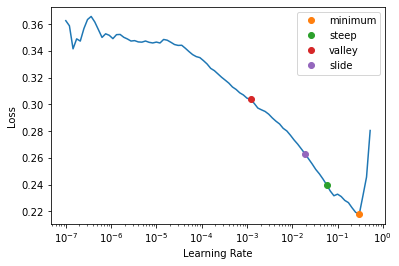

In [13]:
learn = tabular_learner(
    dls, metrics=[F1Score(average='macro'), BalancedAccuracy(), BrierScore(pos_label=0)],
    loss_func=FocalLossFlat(gamma=2),
    # loss_func=BCEWithLogitsLossFlat(),
    cbs=[
            # EarlyStoppingCallback(monitor='f1_score', min_delta=0.0001, patience=5),
            SaveModelCallback(fname='best', monitor='f1_score'),
            SaveModelCallback(fname='end', at_end=True)
        ]
    )
lr_min, lr_steep, lr_valley, lr_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [14]:
with exp.train():
    # learn.fit_one_cycle(5, lr_min)
    learn.fit_sgdr(5,2)


exp.log_model("FastAI Best Model", "models/best.pth")
exp.log_model("FastAI Final Model", "models/end.pth")


epoch,train_loss,valid_loss,f1_score,balanced_accuracy_score,brier_score_loss,time
0,0.072751,0.073170,0.530845,0.528679,0.909333,00:24
1,0.069143,0.072219,0.528962,0.527701,0.909593,00:23
2,0.070521,0.073453,0.533217,0.529956,0.909247,00:24
3,0.071097,0.073135,0.532227,0.529410,0.909182,00:23
4,0.069867,0.073566,0.537834,0.532487,0.909030,00:23
5,0.064291,0.074405,0.542983,0.535395,0.908943,00:23
6,0.068808,0.074544,0.538312,0.532762,0.909160,00:23
7,0.070923,0.073823,0.534314,0.530574,0.909442,00:23
8,0.070632,0.073686,0.544234,0.536103,0.908379,00:23
9,0.066519,0.075063,0.538916,0.533081,0.908813,00:23


Better model found at epoch 0 with f1_score value: 0.5308450235958542.
Better model found at epoch 0 with valid_loss value: 0.07317013293504715.
Better model found at epoch 1 with valid_loss value: 0.07221902906894684.
Better model found at epoch 2 with f1_score value: 0.533217325090669.
Better model found at epoch 4 with f1_score value: 0.5378336594040497.
Better model found at epoch 5 with f1_score value: 0.5429828493241171.
Better model found at epoch 8 with f1_score value: 0.544234270224334.
Better model found at epoch 11 with f1_score value: 0.5491793208511474.
Better model found at epoch 12 with f1_score value: 0.5565019580417427.


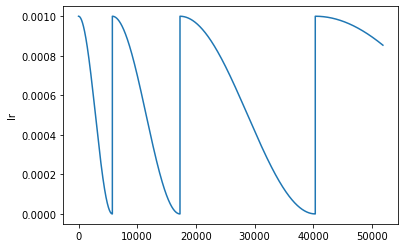

In [ ]:
learn.recorder.plot_sched()

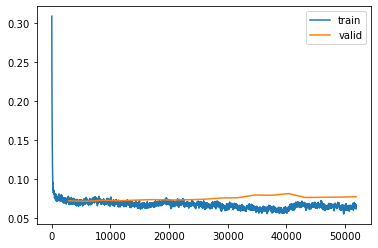

In [ ]:
learn.recorder.plot_loss()

In [ ]:
test_df = valid_df.copy()
test_df.drop([target], axis=1, inplace=True)
test_df.fillna({'angle': 0}, inplace=True)
dl = learn.dls.test_dl(test_df, ignore_exceptions=True)
y_pred = learn.get_preds(dl=dl)

y_val_pred = np.argmin(y_pred[0], axis=1)
val_y_pred_proba = np.array(y_pred[0][:,0])
y_val_binary = y_val.replace({'Shot': 0, 'Goal': 1}).to_list()

COMET ERROR: Failed to log asset data as JSON


F1 Score (Macro) Validation: 0.5586648456795256
Brier Score Validation: 0.10688635403464301
[[70967  1746]
 [ 6856   909]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     72713
           1       0.34      0.12      0.17      7765

    accuracy                           0.89     80478
   macro avg       0.63      0.55      0.56     80478
weighted avg       0.86      0.89      0.87     80478

Our Model: ROC AUC=0.547
Random: ROC AUC=0.500


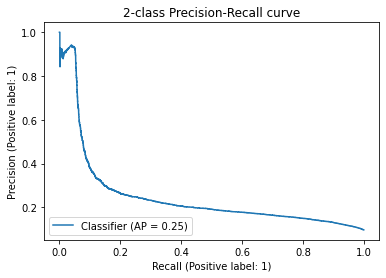

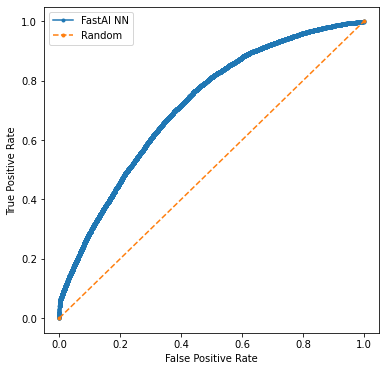

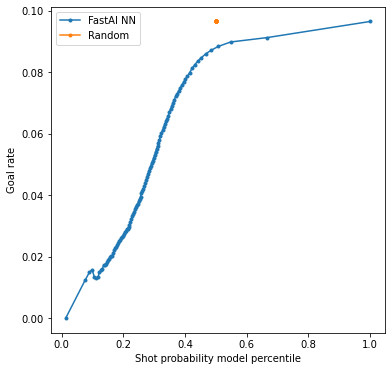

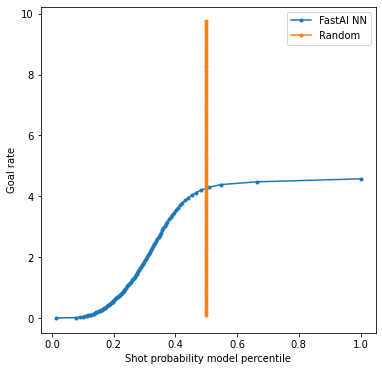

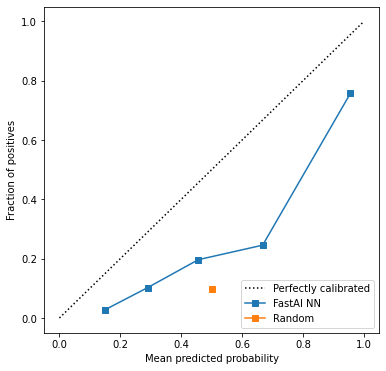

In [ ]:
plot_metrics(learn, y_val_pred, val_y_pred_proba, y_val_binary)

In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/meriembchaaben/ift6758/dd864f6af8094e1ab1c19fbcb4115278
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Brier Score Validation      : 0.10688635403464301
COMET INFO:     F1 Score (Macro) Validation : 0.5586648456795256
COMET INFO:     ROC AUC                     : 0.5465257675943179
COMET INFO:     loss [18]                   : (0.11953404545783997, 0.9388675689697266)
COMET INFO:     train_loss [10375]          : (0.02353893592953682, 0.282754510641098)
COMET INFO:   Others:
COMET INFO:     Name : Question6/YourBestShot-fastai-FL-ES
COMET INFO:   Parameters:
COMET INFO:     constant     : 1
COMET INFO:     random_state : 1
COMET INFO:     strategy     : uniform
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET IN